In [27]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import json
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus

## IMDB

In [51]:
#origDF = pd.read_json('data/screenplay.json')
movieDF = pd.read_json('data/movie_novels.json')
#bookDF = pd.read_json('data/wikibooks.json')

In [52]:
movieDF.shape

(10000, 11)

In [53]:
# remove min from runtime and convert to int
movieDF['runtime'] = movieDF.runtime.str.replace(' min','')
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,year
0,None,None,None,[ Drama],Call the Midwife,TV-PG,2012 (UK),60,http://www.imdb.com/title/tt1983079/?ref_=kw_l...,8.4,NaN
1,"$217,536,138","$125,000,000",Ron Howard,"[ Mystery, Thriller]",The Da Vinci Code,PG-13,19 May 2006 (USA),149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,2006.0
2,"$13,060,843","$5,000,000",Spike Lee,[ Drama],25th Hour,R,10 January 2003 (USA),135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,2002.0
3,"$9,170,214","$11,000,000",Lasse Hallström,[ Drama],What's Eating Gilbert Grape,PG-13,4 March 1994 (USA),118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,1993.0
4,"$81,001,787","$29,000,000",Nick Cassavetes,"[ Drama, Romance]",The Notebook,PG-13,25 June 2004 (USA),123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,2004.0


In [54]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
box_office      2047 non-null object
budget          2538 non-null object
director        8873 non-null object
genre           10000 non-null object
name            10000 non-null object
rating          5657 non-null object
release_date    9612 non-null object
runtime         8371 non-null object
url             10000 non-null object
user_rating     9666 non-null float64
year            8870 non-null float64
dtypes: float64(2), object(9)
memory usage: 937.5+ KB


In [55]:
movieDF.box_office.isnull().sum()

7953

In [56]:
movieDF.dropna(subset=['box_office'],axis=0,inplace=True)

In [57]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 1 to 9939
Data columns (total 11 columns):
box_office      2047 non-null object
budget          1275 non-null object
director        2047 non-null object
genre           2047 non-null object
name            2047 non-null object
rating          1953 non-null object
release_date    2047 non-null object
runtime         1905 non-null object
url             2047 non-null object
user_rating     2047 non-null float64
year            2047 non-null float64
dtypes: float64(2), object(9)
memory usage: 191.9+ KB


In [58]:
movieDF.dropna(subset=['budget'],axis=0,inplace=True)

In [59]:
# replace the dollar signs in currency fields
# box office
movieDF['box_office'] = movieDF['box_office'].str.replace('$','')
movieDF['box_office'] = movieDF['box_office'].str.replace(',','')
movieDF['box_office'] = movieDF['box_office'].astype(int)
# budget
movieDF['budget'] = movieDF['budget'].str.replace('$','')
movieDF['budget'] = movieDF['budget'].str.replace(',','')
#movieDF['budget'] = movieDF['budget'].astype(int)

In [60]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 1 to 9939
Data columns (total 11 columns):
box_office      1275 non-null int64
budget          1275 non-null object
director        1275 non-null object
genre           1275 non-null object
name            1275 non-null object
rating          1254 non-null object
release_date    1275 non-null object
runtime         1213 non-null object
url             1275 non-null object
user_rating     1275 non-null float64
year            1275 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 119.5+ KB


In [61]:
# Fill Null values with 0 and covnert to int
movieDF['runtime'] = movieDF.runtime.fillna(value=0)

In [62]:
movieDF['runtime'] = movieDF.runtime.astype('int')

In [63]:
movieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 1 to 9939
Data columns (total 11 columns):
box_office      1275 non-null int64
budget          1275 non-null object
director        1275 non-null object
genre           1275 non-null object
name            1275 non-null object
rating          1254 non-null object
release_date    1275 non-null object
runtime         1275 non-null int64
url             1275 non-null object
user_rating     1275 non-null float64
year            1275 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 119.5+ KB


In [64]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,year
1,217536138,125000000,Ron Howard,"[ Mystery, Thriller]",The Da Vinci Code,PG-13,19 May 2006 (USA),149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,2006.0
2,13060843,5000000,Spike Lee,[ Drama],25th Hour,R,10 January 2003 (USA),135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,2002.0
3,9170214,11000000,Lasse Hallström,[ Drama],What's Eating Gilbert Grape,PG-13,4 March 1994 (USA),118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,1993.0
4,81001787,29000000,Nick Cassavetes,"[ Drama, Romance]",The Notebook,PG-13,25 June 2004 (USA),123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,2004.0
5,26384681,100000000,Timur Bekmambetov,"[ Action, Adventure, Drama, History]",Ben-Hur,PG-13,19 August 2016 (USA),123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,2016.0


In [65]:
dateDF = movieDF.release_date.str.split(expand=True)

In [66]:
movieDF.drop('year',axis=1,inplace=True)

In [67]:
dateDF.head()

,0,1,2,3,4
1,19,May,2006,(USA),None
2,10,January,2003,(USA),None
3,4,March,1994,(USA),None
4,25,June,2004,(USA),None
5,19,August,2016,(USA),None


In [68]:
dateDF.columns = ['day','month','year','country','x1']

In [69]:
dateDF.to_csv('dates.csv')

In [70]:
dateDF.drop(['x1'],inplace=True,axis=1)

In [71]:
dropdates = [320,424,789,982,1067,1128,1353,1695,1739,2120,2600,2755,3223,
             3876,3916,4882,5609,5978,6539,6618,8513,9046]

In [72]:
dateDF.head()

,day,month,year,country
1,19,May,2006,(USA)
2,10,January,2003,(USA)
3,4,March,1994,(USA)
4,25,June,2004,(USA)
5,19,August,2016,(USA)


In [73]:
movieDF.drop(dropdates, axis=0,inplace=True)

In [74]:
movieDF = movieDF.join(dateDF)

In [75]:
#dateDF['monthnum'] = dateDf['month'].replace([])

In [76]:
movieDF.shape

(1253, 14)

In [77]:
movieDF.columns.tolist()

['box_office',
 'budget',
 'director',
 'genre',
 'name',
 'rating',
 'release_date',
 'runtime',
 'url',
 'user_rating',
 'day',
 'month',
 'year',
 'country']

In [78]:
movieDF.year.unique()

array(['2006', '2003', '1994', '2004', '2016', '1987', '2011', '2002',
       '2015', '2009', '1993', '2010', '1977', '2017', '1984', '2001',
       '2014', '1953', '1997', '2000', '1995', '2007', '2008', '2012',
       '1990', '1961', '1983', '1986', '1992', '1957', '1985', '1956',
       '1999', '2005', '1988', '1931', '1965', '1979', '1933', '1940',
       '2013', '1998', '1969', '1996', '1974', '1978', '1964', '1989',
       '1991', '1963', '1980', '1967', '1971', '1972', '1976', '1962',
       '1960', '1982', '1981', '1973', '1958', '1947', '1968', '1975',
       '1970', '1944', '1949', '1955', '1954', '1915', '1966', '1943',
       '1926', '1928', '1945', '1942', '1959', '1934', '1930', '1951',
       '1939', '1952', '1946', '1937', '1936', '1925', '1916', '1922',
       '1929', '1927', '1919', '1924'], dtype=object)

In [79]:
movieDF.day.unique()

array(['19', '10', '4', '25', '9', '21', '1', '18', '8', '2', '16', '15',
       '24', '7', '6', '3', '26', '14', '23', '28', '31', '5', '30', '22',
       '17', '27', '11', '29', '20', '12', '13'], dtype=object)

In [80]:
movieDF.month.unique()

array(['May', 'January', 'March', 'June', 'August', 'October', 'July',
       'December', 'September', 'February', 'April', 'November'], dtype=object)

In [82]:
monthDict = {'January':1, 'February':2, 'March':3, 'April': 4, 'May': 5, 'June':6, 'July':7,
            'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

In [83]:
movieDF['monthnums'] = movieDF.month.map(monthDict)

In [84]:
movieDF['release_date'] = movieDF['monthnums'].map(str)+"/"+movieDF['day'].map(str)+'/'+movieDF['year'].map(str)

In [85]:
movieDF['release_date'] = pd.to_datetime(movieDF.release_date)

In [86]:
#Cleanup Genres and convert to indicator variables
movieDF['genre'] = movieDF.genre.apply(lambda x: ','.join(x))
movieDF['genre'] = movieDF.genre.str.strip()

In [87]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,day,month,year,country,monthnums
1,217536138,125000000,Ron Howard,"Mystery, Thriller",The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,19,May,2006,(USA),5
2,13060843,5000000,Spike Lee,Drama,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,10,January,2003,(USA),1
3,9170214,11000000,Lasse Hallström,Drama,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,4,March,1994,(USA),3
4,81001787,29000000,Nick Cassavetes,"Drama, Romance",The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,25,June,2004,(USA),6
5,26384681,100000000,Timur Bekmambetov,"Action, Adventure, Drama, History",Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,19,August,2016,(USA),8


In [88]:
genreDF = movieDF.genre.str.get_dummies(sep = ", ")

In [89]:
genreDF.columns.tolist()

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

Check to see if there are any null values in the data set.

In [90]:
movieDF = movieDF.join(genreDF)

In [91]:
movieDF.head()

,box_office,budget,director,genre,name,rating,release_date,runtime,url,user_rating,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,217536138,125000000,Ron Howard,"Mystery, Thriller",The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,...,0,0,1,0,0,0,0,1,0,0
2,13060843,5000000,Spike Lee,Drama,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,...,0,0,0,0,0,0,0,0,0,0
3,9170214,11000000,Lasse Hallström,Drama,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,...,0,0,0,0,0,0,0,0,0,0
4,81001787,29000000,Nick Cassavetes,"Drama, Romance",The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,...,0,0,0,1,0,0,0,0,0,0
5,26384681,100000000,Timur Bekmambetov,"Action, Adventure, Drama, History",Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,...,0,0,0,0,0,0,0,0,0,0


In [92]:
movieDF.drop('genre',axis=1,inplace=True)

In [94]:
movieDF.columns.tolist()

['box_office',
 'budget',
 'director',
 'name',
 'rating',
 'release_date',
 'runtime',
 'url',
 'user_rating',
 'day',
 'month',
 'year',
 'country',
 'monthnums',
 'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [95]:
movieDF.corr()

,box_office,runtime,user_rating,monthnums,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
box_office,1.000000,0.215258,0.196722,0.060031,0.080975,0.330657,0.092797,-0.040220,-0.026716,-0.065272,...,-0.026361,0.015251,0.062854,-0.096545,0.106816,-0.007989,-0.005134,0.022604,-0.043627,-0.003190
runtime,0.215258,1.000000,0.334117,0.071532,0.036458,0.044909,-0.135915,0.108782,-0.208868,0.033281,...,-0.010273,-0.033602,0.043453,-0.014900,-0.013780,-0.070287,-0.001755,0.011113,0.200725,0.045989
user_rating,0.196722,0.334117,1.000000,0.058184,-0.164773,-0.057023,0.043018,0.105120,-0.106954,0.037571,...,-0.004382,-0.001784,0.021497,0.009299,-0.094356,0.040358,0.034504,-0.107550,0.119524,0.043226
monthnums,0.060031,0.071532,0.058184,1.000000,-0.034914,0.044338,-0.025422,-0.042664,0.008556,0.031008,...,0.002235,0.038040,-0.033717,-0.012483,-0.008241,0.040229,0.001958,-0.045615,0.023198,0.053200
Action,0.080975,0.036458,-0.164773,-0.034914,1.000000,0.262411,-0.052468,-0.074260,-0.140372,0.105069,...,-0.061535,-0.079581,-0.027820,-0.179735,0.221437,-0.012718,-0.025028,0.321861,0.018204,-0.040898
Adventure,0.330657,0.044909,-0.057023,0.044338,0.262411,1.000000,0.240312,-0.069457,-0.040067,-0.182891,...,-0.043576,0.086587,-0.097920,-0.131650,0.172195,-0.014951,-0.054168,-0.077486,-0.001839,0.021296
Animation,0.092797,-0.135915,0.043018,-0.025422,-0.052468,0.240312,1.000000,-0.036820,0.111660,-0.057075,...,0.005559,0.316021,-0.033050,-0.087598,0.034032,0.146428,-0.019762,-0.106134,-0.053046,-0.029709
Biography,-0.040220,0.108782,0.105120,-0.042664,-0.074260,-0.069457,-0.036820,1.000000,-0.030135,-0.055662,...,0.070811,0.016829,-0.080153,0.018729,-0.064349,-0.005392,0.108833,-0.104287,0.015437,0.028306
Comedy,-0.026716,-0.208868,-0.106954,0.008556,-0.140372,-0.040067,0.111660,-0.030135,1.000000,-0.029143,...,0.040198,0.071853,-0.162206,0.060708,-0.099748,0.052442,-0.017460,-0.266943,-0.103242,-0.032113
Crime,-0.065272,0.033281,0.037571,0.031008,0.105069,-0.182891,-0.057075,-0.055662,-0.029143,1.000000,...,-0.002295,-0.082961,0.233026,-0.190578,-0.123964,-0.013258,-0.048032,0.398146,-0.112682,-0.058402


## MVP

In [98]:
movieDF.budget.isnull().sum()

0

In [99]:
movieDF['day'] = pd.to_datetime(movieDF['release_date'].dt.day)

In [100]:
movieDF['year'] = pd.to_datetime(movieDF['release_date'].dt.year)

In [101]:
movieDF['monthnums'] = pd.to_datetime(movieDF['release_date'].dt.month)

In [102]:
idx = movieDF.budget.str.contains('\D', 
             flags=re.IGNORECASE, regex=True, na=False)

In [103]:
nonUSDF = movieDF[idx]

In [104]:
nonUSDF.shape

(102, 36)

In [108]:
usMovieDF = movieDF[-idx]

In [109]:
usMovieDF.shape

(1151, 36)

In [110]:
usMovieDF.head()

,box_office,budget,director,name,rating,release_date,runtime,url,user_rating,day,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,217536138,125000000,Ron Howard,The Da Vinci Code,PG-13,2006-05-19,149,http://www.imdb.com/title/tt0382625/?ref_=kw_l...,6.6,1970-01-01 00:00:00.000000019,...,0,0,1,0,0,0,0,1,0,0
2,13060843,5000000,Spike Lee,25th Hour,R,2003-01-10,135,http://www.imdb.com/title/tt0307901/?ref_=kw_l...,7.7,1970-01-01 00:00:00.000000010,...,0,0,0,0,0,0,0,0,0,0
3,9170214,11000000,Lasse Hallström,What's Eating Gilbert Grape,PG-13,1994-03-04,118,http://www.imdb.com/title/tt0108550/?ref_=kw_l...,7.8,1970-01-01 00:00:00.000000004,...,0,0,0,0,0,0,0,0,0,0
4,81001787,29000000,Nick Cassavetes,The Notebook,PG-13,2004-06-25,123,http://www.imdb.com/title/tt0332280/?ref_=kw_l...,7.9,1970-01-01 00:00:00.000000025,...,0,0,0,1,0,0,0,0,0,0
5,26384681,100000000,Timur Bekmambetov,Ben-Hur,PG-13,2016-08-19,123,http://www.imdb.com/title/tt2638144/?ref_=kw_l...,5.7,1970-01-01 00:00:00.000000019,...,0,0,0,0,0,0,0,0,0,0


In [111]:
usMovieDF['budget'] = usMovieDF.budget.astype('int')

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [112]:
usMovieDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 1 to 9939
Data columns (total 36 columns):
box_office      1151 non-null int64
budget          1151 non-null int64
director        1151 non-null object
name            1151 non-null object
rating          1141 non-null object
release_date    1151 non-null datetime64[ns]
runtime         1151 non-null int64
url             1151 non-null object
user_rating     1151 non-null float64
day             1151 non-null datetime64[ns]
month           1151 non-null object
year            1151 non-null datetime64[ns]
country         1151 non-null object
monthnums       1151 non-null datetime64[ns]
Action          1151 non-null int64
Adventure       1151 non-null int64
Animation       1151 non-null int64
Biography       1151 non-null int64
Comedy          1151 non-null int64
Crime           1151 non-null int64
Drama           1151 non-null int64
Family          1151 non-null int64
Fantasy         1151 non-null int64
Film-Noir       1151 

### Split Numeric and Categorical Data

In [114]:
print(usMovieDF.dtypes.value_counts())

int64             25
object             6
datetime64[ns]     4
float64            1
dtype: int64


In [115]:
movie_numeric = usMovieDF.select_dtypes(include=['int64','float64'])
movie_categories = usMovieDF.select_dtypes(exclude=['int64','float64'])

In [117]:
movie_numeric.columns.tolist()

['box_office',
 'budget',
 'runtime',
 'user_rating',
 'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

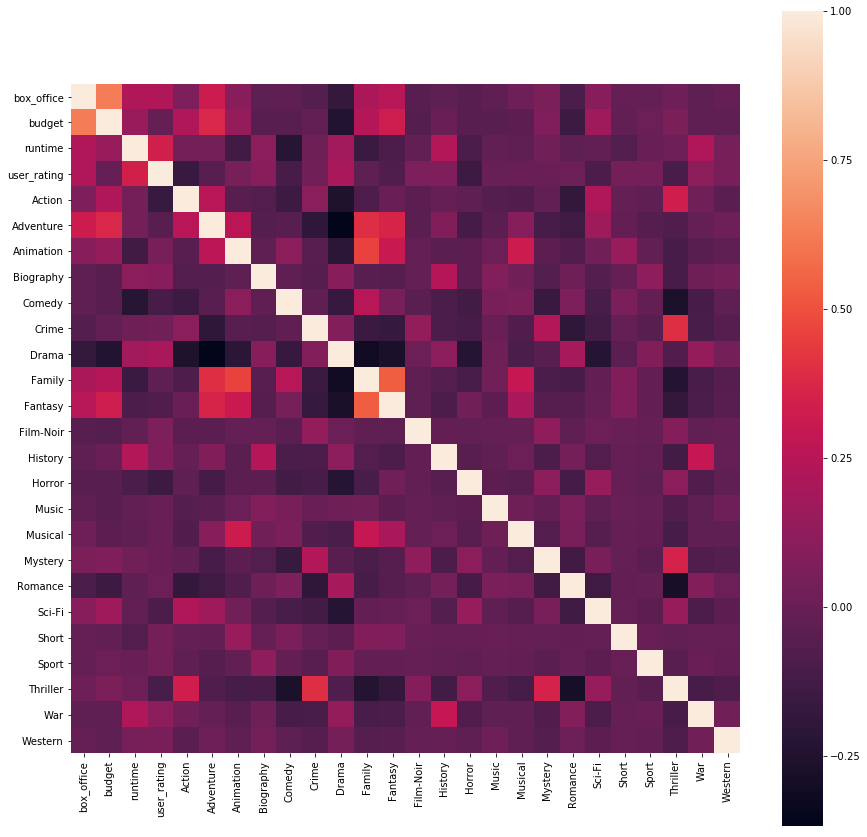

In [125]:
movie_corr = movie_numeric.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(movie_corr, square=True)

In [126]:
movie_corr

,box_office,budget,runtime,user_rating,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
box_office,1.000000,0.626897,0.224877,0.224033,0.069150,0.319997,0.102111,-0.035210,-0.026631,-0.065641,...,-0.026815,0.017005,0.059850,-0.097402,0.099361,-0.009599,-0.010385,0.022215,-0.033740,-0.007402
budget,0.626897,1.000000,0.152196,-0.007670,0.223162,0.371048,0.141559,-0.055528,-0.056799,-0.023510,...,-0.055878,-0.040890,0.072841,-0.144124,0.172933,-0.022694,0.010298,0.064726,-0.026860,-0.034009
runtime,0.224877,0.152196,1.000000,0.340804,0.033821,0.036355,-0.130681,0.113538,-0.225732,0.015655,...,-0.023572,-0.028308,0.030654,-0.036360,-0.021646,-0.075967,-0.002982,0.019444,0.229814,0.047114
user_rating,0.224033,-0.007670,0.340804,1.000000,-0.164569,-0.054072,0.048772,0.099706,-0.111132,0.030326,...,-0.002543,0.004385,0.005524,0.011566,-0.093355,0.042803,0.039297,-0.105573,0.116624,0.051585
Action,0.069150,0.223162,0.033821,-0.164569,1.000000,0.254815,-0.053047,-0.072240,-0.149232,0.107202,...,-0.063648,-0.082684,-0.021884,-0.181609,0.223109,-0.013768,-0.028454,0.336859,0.023664,-0.044301
Adventure,0.319997,0.371048,0.036355,-0.054072,0.254815,1.000000,0.261598,-0.064860,-0.049716,-0.196825,...,-0.043938,0.094962,-0.106233,-0.140799,0.172972,-0.016167,-0.058596,-0.083035,-0.011130,0.020456
Animation,0.102111,0.141559,-0.130681,0.048772,-0.053047,0.261598,1.000000,-0.035026,0.109166,-0.053047,...,0.008825,0.320859,-0.040370,-0.082751,0.023312,0.153434,-0.020541,-0.113877,-0.050741,-0.030347
Biography,-0.035210,-0.055528,0.113538,0.099706,-0.072240,-0.064860,-0.035026,1.000000,-0.027774,-0.059391,...,0.085565,0.025097,-0.075866,0.012271,-0.063612,-0.005374,0.120355,-0.105936,0.011756,0.035166
Comedy,-0.026631,-0.056799,-0.225732,-0.111132,-0.149232,-0.049716,0.109166,-0.027774,1.000000,-0.029991,...,0.050550,0.061635,-0.160459,0.066827,-0.101742,0.054589,-0.018414,-0.269942,-0.108945,-0.031354
Crime,-0.065641,-0.023510,0.015655,0.030326,0.107202,-0.196825,-0.053047,-0.059391,-0.029991,1.000000,...,0.004090,-0.082684,0.233638,-0.201515,-0.126544,-0.013768,-0.049902,0.399683,-0.104899,-0.059012


In [1]:
# sns.jointplot('user_rating', 'box_office',movieDF, kind="reg")
# print("R^2:", stats.pearsonr(X.values.flatten(),y.values)[0]**2)

In [309]:
#movieDF[movieDF['budget'].str.contains('€')]
#movieDF.budget.value_counts()

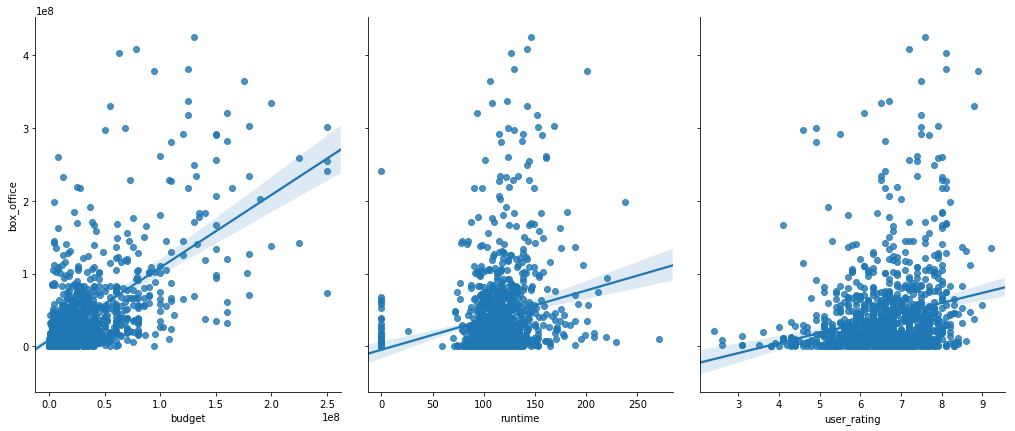

In [113]:
sns.pairplot(usMovieDF, x_vars=['budget','runtime', 'user_rating'], 
             y_vars='box_office', size=6, aspect=0.8, kind='reg')

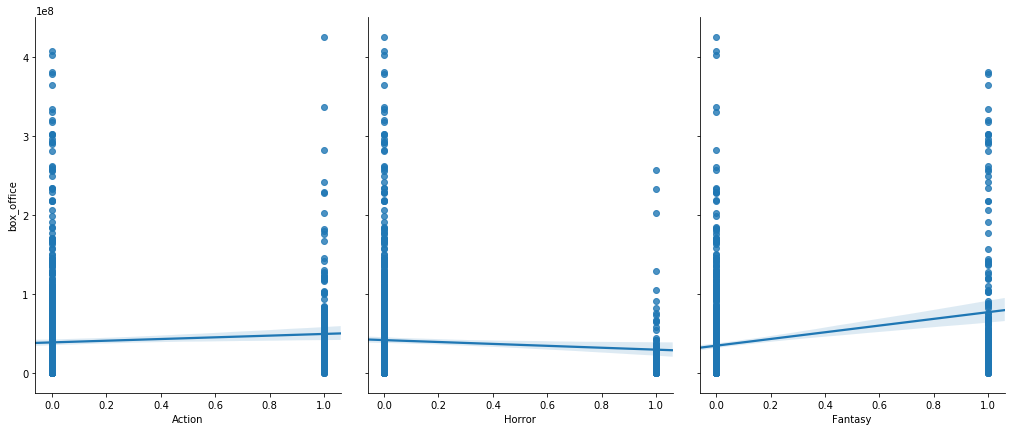

In [132]:
sns.pairplot(usMovieDF, x_vars=['Action','Horror', 'Fantasy'], 
             y_vars='box_office', size=6, aspect=0.8, kind='reg')

In [130]:
y= movie_numeric['box_office']
X=movie_numeric[['budget','runtime','user_rating']]

In [137]:
lr=LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.41026284355552844